# Xist SNP Analysis: Visualization

This notebook provides detailed visualizations for the allelic quantification results. You can fine-tune plot settings here before finalizing reports.

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
import numpy as np

# Set your results directory here
RESULTS_DIR = "/Volumes/guttman/users/gmgao/Data_seq/Consolidated-2026Feb-DoxSeqAmpliconNanopore/results/"
QUANT_DIR = os.path.join(RESULTS_DIR, "quantification")
PLOT_DIR = os.path.join(QUANT_DIR, "plots")
os.makedirs(PLOT_DIR, exist_ok=True)

## 1. SNP Match Heatmaps

Generates 2D heatmaps of B6 vs. Cast SNP matches for each sample.

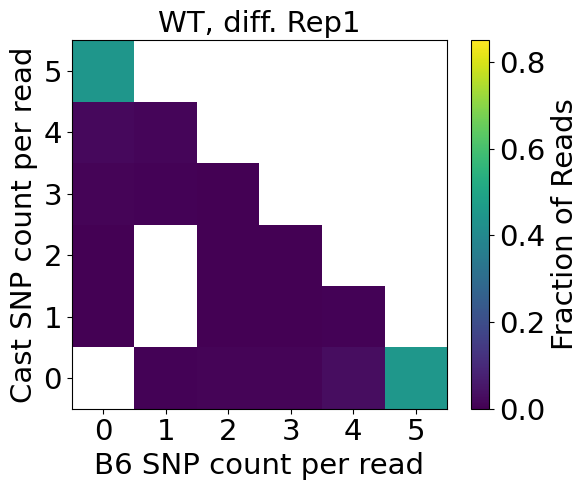

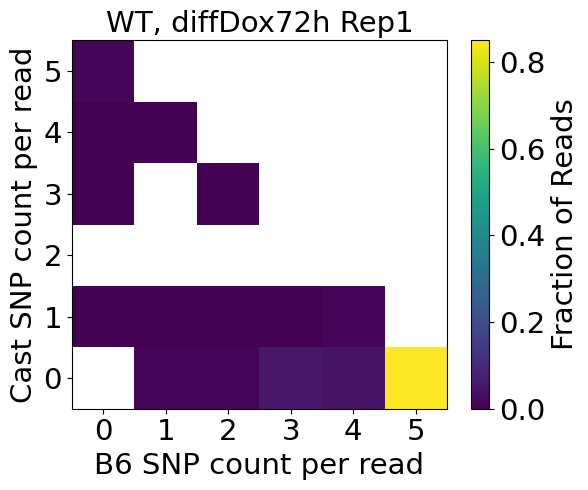

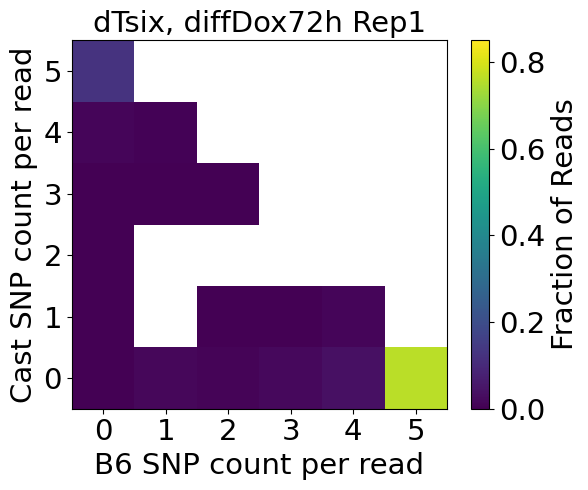

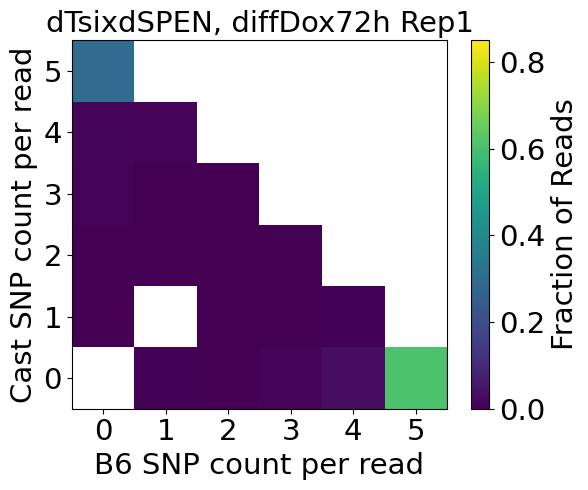

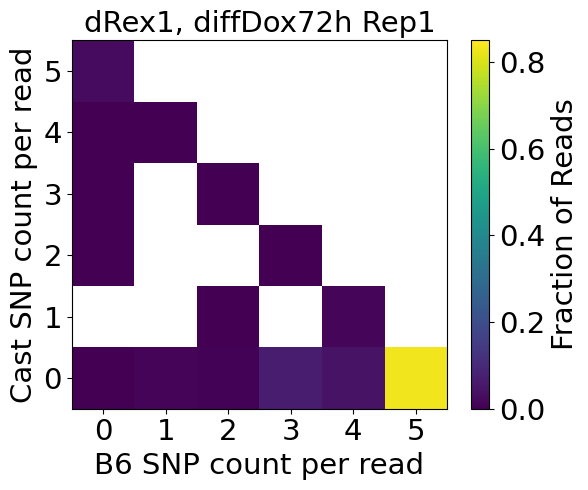

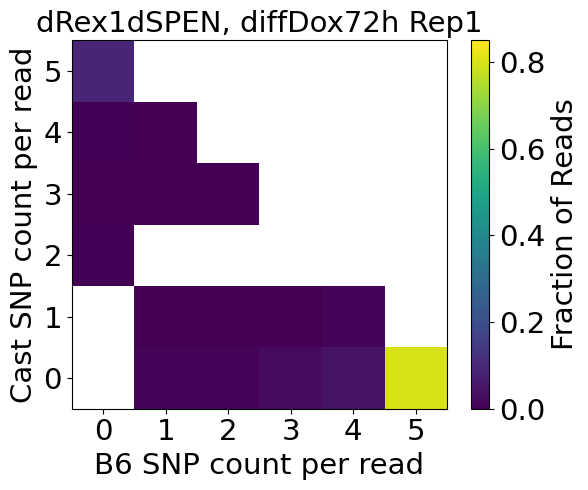

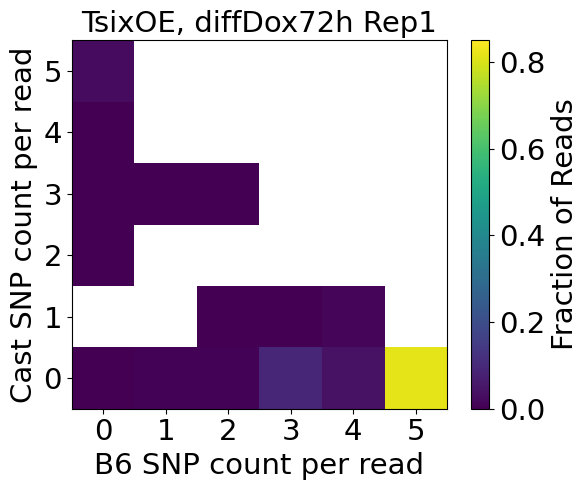

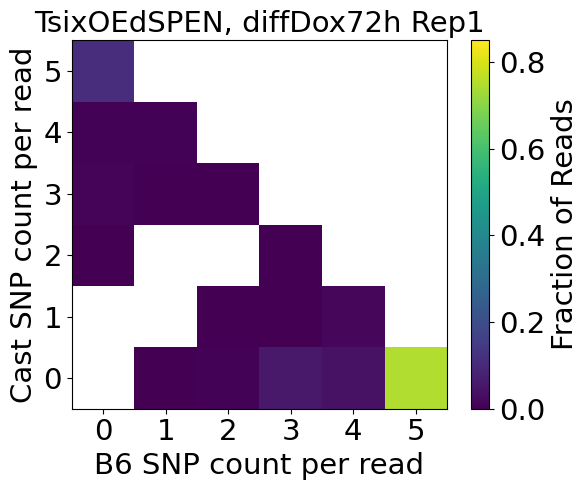

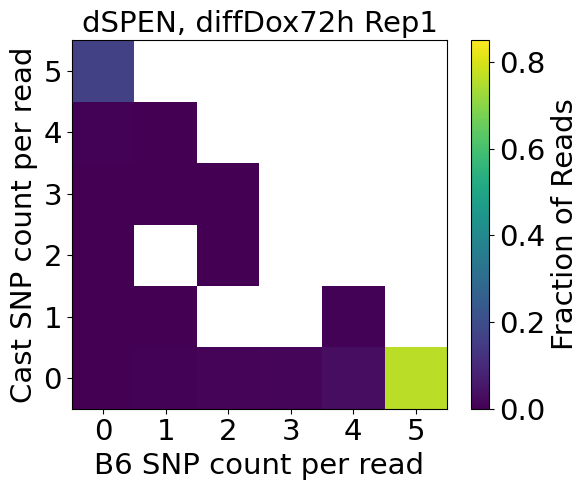

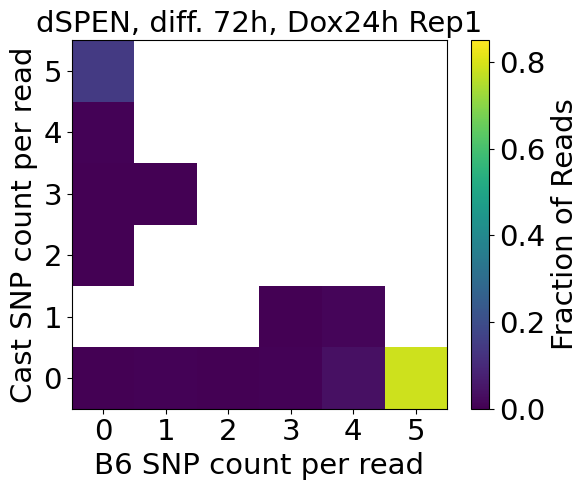

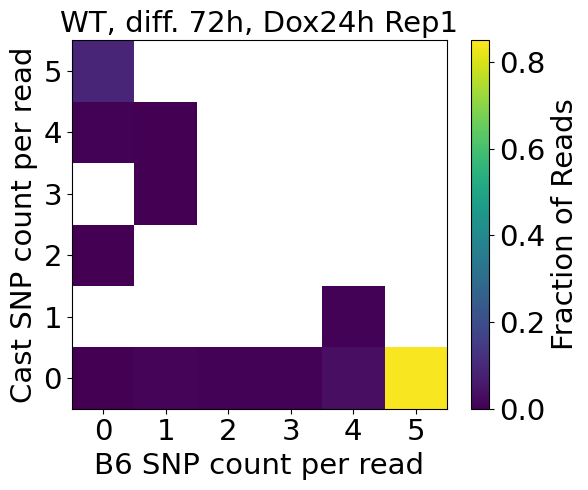

In [9]:
def clean_sample_name(sample, rename_rules=None):
    """
    Cleans sample names for plotting titles.
    Example: 'XistExMixAmp-A_WT_diff-Rep1' -> 'WT, diff. Rep1'
    """
    if rename_rules:
        for old, new in rename_rules.items():
            sample = sample.replace(old, new)

    # Default cleaning if no rules or after rules
    # Remove common prefix like 'XistExMixAmp-A_'
    if "_" in sample and sample.startswith("Xist"):
        sample = sample.split("_", 1)[1]

    return sample.replace("_", ", ").replace("-", " ")


def plot_snp_heatmap(quant_dir, output_dir, rename_rules=None, fontsize=21):
    quant_files = glob.glob(os.path.join(quant_dir, "*_quant.csv"))

    for f in quant_files:
        sample_raw = os.path.basename(f).replace("_quant.csv", "")
        sample_clean = clean_sample_name(sample_raw, rename_rules)
        df = pd.read_csv(f)

        plt.figure(figsize=(6, 5))

        # Center ticks by defining bin edges between integers
        # For 0-5 SNPs, we want bins centered at 0, 1, 2, 3, 4, 5
        bins = np.arange(-0.5, 6.5, 1)

        h = plt.hist2d(
            df["B6_Matches"],
            df["Cast_Matches"],
            bins=bins,
            cmap="viridis",
            density=True,
            cmin=1e-7,
        )

        cbar = plt.colorbar()
        cbar.mappable.set_clim(0, 0.85)
        cbar.set_label("Fraction of Reads", fontsize=fontsize)
        cbar.ax.tick_params(labelsize=fontsize)

        plt.xlabel("B6 SNP count per read", fontsize=fontsize)
        plt.ylabel("Cast SNP count per read", fontsize=fontsize)
        plt.title(f"{sample_clean}", fontsize=fontsize)

        # Force ticks to be integers 0-5 and center them
        plt.xticks(range(6), fontsize=fontsize)
        plt.yticks(range(6), fontsize=fontsize)

        # plt.grid(True, linestyle="--", alpha=0.3)

        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, f"{sample_raw}_snp_heatmap.png"), dpi=300)
        plt.show()
        plt.close()


# Example rename rules:
SAMPLE_RENAME_RULES = {"diff-Rep1": "diff. Rep1", "diff72h": "diff. 72h"}

plot_snp_heatmap(QUANT_DIR, PLOT_DIR, rename_rules=SAMPLE_RENAME_RULES)

## 2. Allele Quantification: Horizontal Stacked Barplot

Visualizes the distribution of B6 and Cast reads across experiments, matching the summary report table.

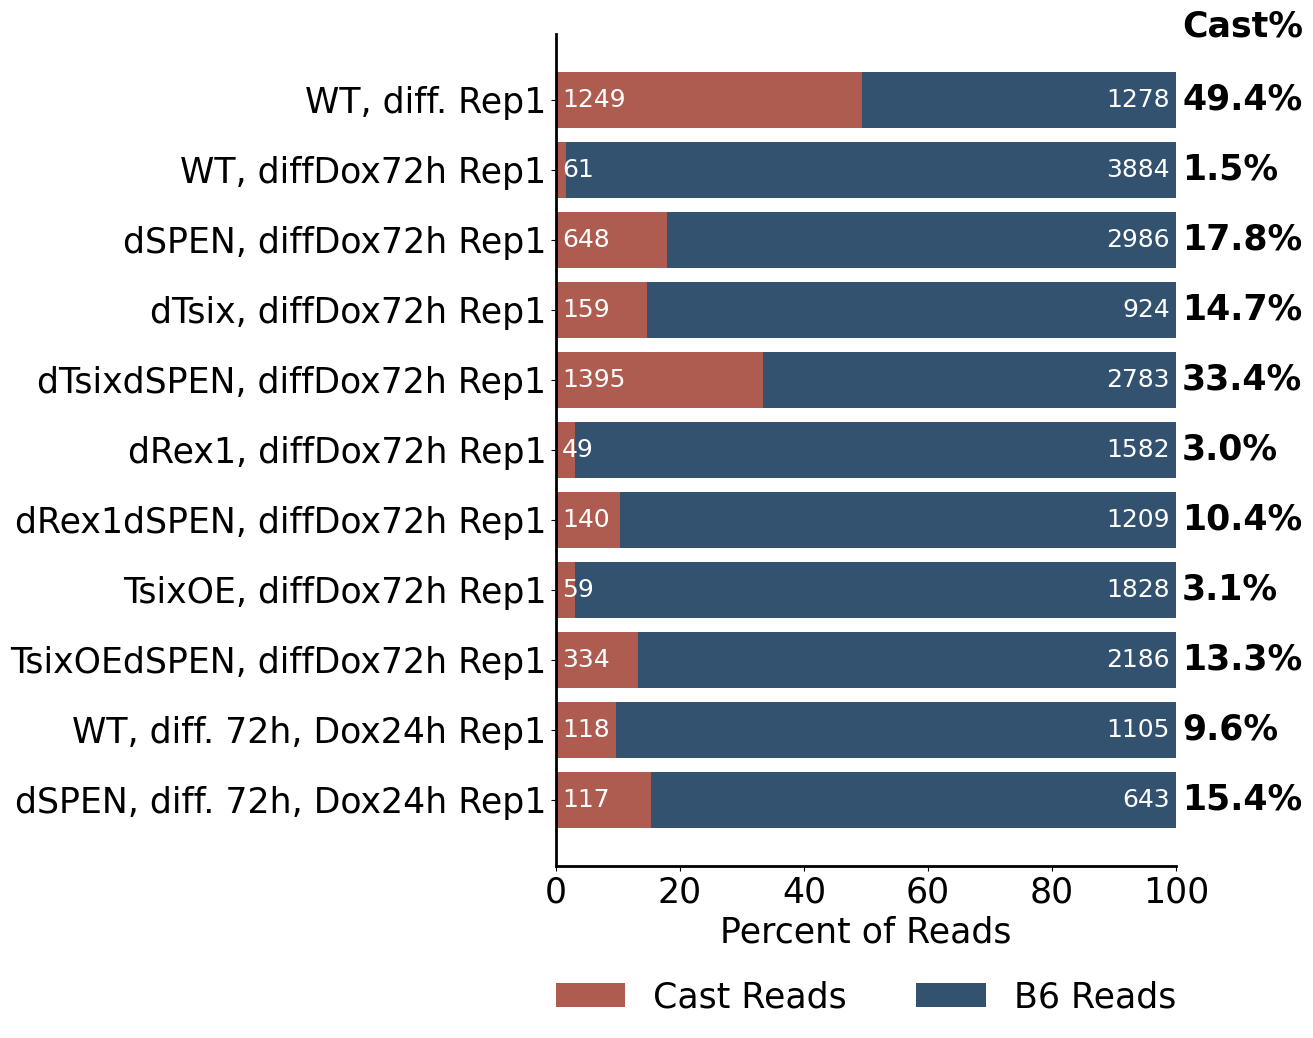

In [53]:
def plot_allele_summary(
    quant_dir,
    output_dir,
    rename_rules=None,
    sample_order=None,
    fontsize=25,
    fname_save="allele_quantification_summary_refined.png",
):
    quant_files = sorted(glob.glob(os.path.join(quant_dir, "*_quant.csv")))
    data = []

    for f in quant_files:
        sample_raw = os.path.basename(f).replace("_quant.csv", "")
        sample_clean = clean_sample_name(sample_raw, rename_rules)
        df = pd.read_csv(f)

        b6 = len(df[df["Allele"].str.startswith("B6", na=False)])
        cast = len(df[df["Allele"].str.startswith("Cast", na=False)])

        data.append({"Sample": sample_clean, "B6": b6, "Cast": cast})

    summary_df = pd.DataFrame(data)
    if summary_df.empty:
        print("No quantification data found.")
        return

    # Handle sample ordering and selection
    if sample_order:
        sample_order = sample_order[::-1]  # Reverse to natural order
        # Filter summary_df to only include samples in sample_order
        summary_df = summary_df[summary_df["Sample"].isin(sample_order)]
        summary_df["Sample"] = pd.Categorical(
            summary_df["Sample"], categories=sample_order, ordered=True
        )
        summary_df = summary_df.sort_values("Sample")
    else:
        # Default to reversed order
        summary_df = summary_df[::-1].reset_index(drop=True)

    # Calculate percentages
    summary_df["Total"] = summary_df["B6"] + summary_df["Cast"]
    summary_df["B6_pct"] = (summary_df["B6"] / summary_df["Total"]) * 100
    summary_df["Cast_pct"] = (summary_df["Cast"] / summary_df["Total"]) * 100

    # Plotting
    fig, ax = plt.subplots(figsize=(8, 0.8 * len(summary_df) + 2))

    samples_list = summary_df["Sample"]
    b6_pct = summary_df["B6_pct"]
    cast_pct = summary_df["Cast_pct"]

    # Plot Cast on left (primary metric) and B6 on right
    ax.barh(samples_list, cast_pct, label="Cast Reads", color="#9a3324", alpha=0.8)
    ax.barh(
        samples_list,
        b6_pct,
        left=cast_pct,
        label="B6 Reads",
        color="#00274c",
        alpha=0.8,
    )

    # Add Cast Ratio labeling and raw counts
    for i, (idx, row) in enumerate(summary_df.iterrows()):
        ratio = row["Cast"] / row["Total"] if row["Total"] > 0 else 0
        # Percentage label (outside)
        ax.text(
            101,
            i,
            f"{ratio*100:.1f}%",
            va="center",
            fontweight="bold",
            color="black",
            fontsize=fontsize,
        )
        # Raw count for Cast (leftmost inside)
        ax.text(
            1,
            i,
            f"{int(row['Cast'])}",
            va="center",
            ha="left",
            color="white",
            fontsize=fontsize - 7,
        )
        # Raw count for B6 (rightmost inside)
        ax.text(
            99,
            i,
            f"{int(row['B6'])}",
            va="center",
            ha="right",
            color="white",
            fontsize=fontsize - 7,
        )
    # Add "Cast%" label above the column for better clarity
    ax.text(
        101,
        len(summary_df) - 0.2,
        "Cast%",
        va="bottom",
        fontweight="bold",
        fontsize=fontsize,
    )

    ax.set_xlabel("Percent of Reads", fontsize=fontsize)
    ax.tick_params(axis="both", which="major", labelsize=fontsize)

    # Ensure axis linewidth is at least 1
    for spine in ax.spines.values():
        spine.set_linewidth(2)

    # Hide top and right spines
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    ax.set_xlim(0, 100)

    ax.legend(
        loc="upper center",
        bbox_to_anchor=(0.5, -0.1),
        # bbox_to_anchor=(0.5, -0.15),
        ncol=2,
        frameon=False,
        fontsize=fontsize,
    )

    plt.savefig(
        os.path.join(output_dir, fname_save),
        dpi=300,
        bbox_inches="tight",
    )
    plt.show()


# Define conditions to plot below. Comment out strings to exclude them from the plot.
SAMPLE_SELECTION = [
    "WT, diff. Rep1",
    "WT, diffDox72h Rep1",
    "dSPEN, diffDox72h Rep1",
    "dTsix, diffDox72h Rep1",
    "dTsixdSPEN, diffDox72h Rep1",
    "dRex1, diffDox72h Rep1",
    "dRex1dSPEN, diffDox72h Rep1",
    "TsixOE, diffDox72h Rep1",
    "TsixOEdSPEN, diffDox72h Rep1",
    "WT, diff. 72h, Dox24h Rep1",
    "dSPEN, diff. 72h, Dox24h Rep1",
]

plot_allele_summary(
    QUANT_DIR,
    PLOT_DIR,
    rename_rules=SAMPLE_RENAME_RULES,
    sample_order=SAMPLE_SELECTION,
    fname_save="allele_quantification-all.png",
    # fname_save="allele_quantification-1-establish_method.png",
    # fname_save="allele_quantification-2-dSPEN.png",
    # fname_save="allele_quantification-3-conversion.png",
    # fname_save="allele_quantification-4-dTsixSeries.png",
    # fname_save="allele_quantification-5-TestIfdTsixEqualsTsixOE.png",
    # fname_save="allele_quantification-6-TestIfRex1TsixBP.png",
)